In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [4]:
import pandas as pd

train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
train_data.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import os
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 0.001
PATIENCE = 2
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 64
EMBEDDING_DIM = 2
EPOCHS = 4
output_dir = "output"
os.makedirs("output", exist_ok=True)
training_progress_dir = os.path.join(output_dir, "training_progress")
os.makedirs(training_progress_dir, exist_ok=True)
model_weights_dir = os.path.join(output_dir, "model_weights")
os.makedirs(model_weights_dir, exist_ok=True)
MODEL_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_autoencoder.pt")
FILE_RECON_BEFORE_TRAINING = os.path.join(output_dir, "reconstruct_before_train.png")
FILE_REAL_BEFORE_TRAINING = os.path.join(
    output_dir, "real_test_images_before_train.png"
)
FILE_RECON_AFTER_TRAINING = os.path.join(output_dir, "reconstruct_after_train.png")
FILE_REAL_AFTER_TRAINING = os.path.join(output_dir, "real_test_images_after_train.png")
LATENT_SPACE_PLOT = os.path.join(output_dir, "embedding_visualize.png")
IMAGE_GRID_EMBEDDINGS_PLOT = os.path.join(output_dir, "image_grid_on_embeddings.png")
CLASS_LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [6]:
import matplotlib
import numpy as np
import torch
import torchvision

import matplotlib.cm as cm
import matplotlib.colors as mcolors
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import torch.nn.functional as F
import pandas as pd
import logging
import os

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm


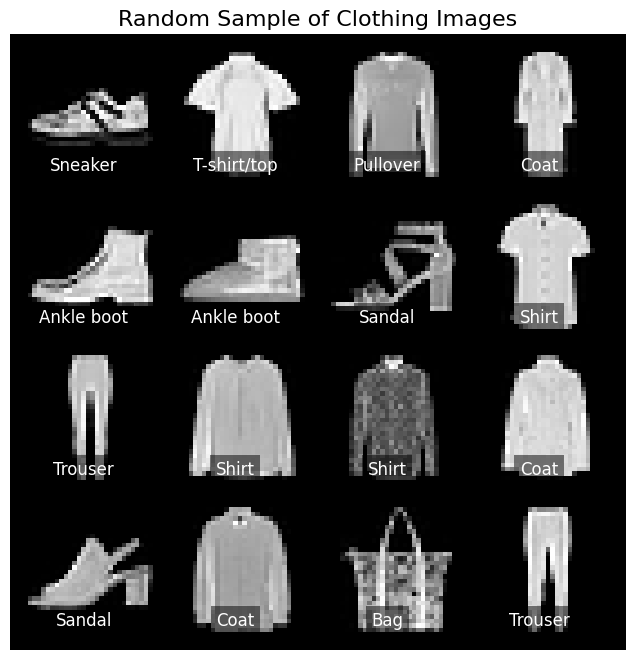

In [7]:

def visualize_images(data_loader, num_images=16, num_images_per_row=4):
    """Visualize a grid of images with their labels."""
    images, labels = next(iter(data_loader))
    random_indices = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[random_indices]
    selected_labels = labels[random_indices]

    grid = torchvision.utils.make_grid(selected_images.cpu(), nrow=num_images_per_row, padding=2, normalize=True)
    grid_np = grid.numpy().transpose((1, 2, 0))
    
    plt.figure(figsize=(num_images_per_row * 2, (num_images // num_images_per_row) * 2))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.title("Random Sample of Clothing Images", fontsize=16)
    
    for i in range(num_images):
        plt.text(
            (i % num_images_per_row) * (selected_images.shape[3] + 2) + selected_images.shape[3] // 2,
            (i // num_images_per_row + 1) * (selected_images.shape[2] + 2) - 5,
            CLASS_LABELS[selected_labels[i].item()],
            fontsize=12,
            ha="center",
            va="center",
            color="white",
            bbox=dict(facecolor="black", alpha=0.5, lw=0),
        )
    
    plt.show()


train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

train_labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)
test_labels = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
    features = F.pad(features, pad=(2, 2, 2, 2))
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)

train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)



    
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Call the function to visualize images from the training dataset
visualize_images(train_loader, num_images=16, num_images_per_row=4)



In [8]:
def extract_random_images(data_loader, num_images):
    all_images, all_labels = [], []
    for images, labels in data_loader:
        all_images.append(images)
        all_labels.append(labels)
        if len(all_images) * data_loader.batch_size > 1000:
            break
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    random_indices = np.random.choice(len(all_images), num_images, replace=False)
    random_images = all_images[random_indices]
    random_labels = all_labels[random_indices]
    return random_images, random_labels

def display_images(images, labels, num_images_per_row, title, filename=None, show=True):
    num_rows = len(images) // num_images_per_row
    grid = torchvision.utils.make_grid(
        images.cpu(), nrow=num_images_per_row, padding=2, normalize=True
    )
    grid_np = grid.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(num_images_per_row * 2, num_rows * 2))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.title(title, fontsize=16)
    for i in range(len(images)):
        row = i // num_images_per_row
        col = i % num_images_per_row
        label_name = CLASS_LABELS[labels[i].item()]
        plt.text(
            col * (images.shape[3] + 2) + images.shape[3] // 2,
            (row + 1) * (images.shape[2] + 2) - 5,
            label_name,
            fontsize=12,
            ha="center",
            va="center",
            color="white",
            bbox=dict(facecolor="black", alpha=0.5, lw=0),
        )
    if show:
        plt.show()
    else:
        plt.savefig(filename, bbox_inches="tight")
        plt.close()

def display_random_images(
    data_loader,
    encoder=None,
    decoder=None,
    file_recon=None,
    file_real=None,
    title_recon=None,
    title_real=None,
    display_real=True,
    num_images=32,
    num_images_per_row=8,
):
    random_images, random_labels = extract_random_images(data_loader, num_images)
    if encoder is not None and decoder is not None:
        encoder.eval()
        decoder.eval()
        random_images = random_images.to(DEVICE)
        random_embeddings = encoder(random_images)
        random_reconstructions = decoder(random_embeddings)
        display_images(
            random_reconstructions.cpu(),
            random_labels,
            num_images_per_row,
            title_recon,
            file_recon,
            show=True,
        )
        if display_real:
            display_images(
                random_images.cpu(),
                random_labels,
                num_images_per_row,
                title_real,
                file_real,
                show=True,
            )
    else:
        display_images(
            random_images, random_labels, num_images_per_row, title="Real Images"
        )

def validate(encoder, decoder, test_loader, criterion):
    encoder.eval()
    decoder.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, _) in tqdm(
            enumerate(test_loader), total=len(test_loader)
        ):
            data = data.to(DEVICE)
            encoded = encoder(data)
            decoded = decoder(encoded)
            loss = criterion(decoded, data)
            running_loss += loss.item()
    return running_loss / len(test_loader)

def get_test_embeddings(test_loader, encoder):
    encoder.eval()
    points, label_idcs = [], []
    for i, data in enumerate(test_loader):
        img, label = [d.to(DEVICE) for d in data]
        proj = encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label
    points = np.array(points)
    label_idcs = np.array(label_idcs)
    return points, label_idcs

def plot_latent_space(test_loader, encoder, show=False):
    points, label_idcs = get_test_embeddings(test_loader, encoder)
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(
        x=points[:, 0],
        y=points[:, 1],
        s=2.0,
        c=label_idcs,
        cmap="tab10",
        alpha=0.9,
        zorder=2,
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
    if show:
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else:
        plt.savefig(LATENT_SPACE_PLOT, bbox_inches="tight")
        plt.close()

def get_random_test_images_embeddings(test_loader, encoder, imgs_visualize=5000):
    all_images, all_labels = [], []
    for batch in test_loader:
        images_batch, labels_batch = batch
        all_images.append(images_batch)
        all_labels.append(labels_batch)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    index = np.random.choice(range(len(all_images)), imgs_visualize)
    images = all_images[index]
    labels = all_labels[index]
    points, _ = get_test_embeddings(test_loader, encoder)
    embeddings = points[index]
    return images, labels, embeddings

def plot_image_grid_on_embeddings(
    test_loader, encoder, decoder, grid_size=15, figsize=12, show=True
):
    _, labels, embeddings = get_random_test_images_embeddings(test_loader, encoder)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    cmap = plt.colormaps.get_cmap("rainbow")
    bounds = np.linspace(0, num_classes, num_classes + 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    scatter = ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        cmap=cmap,
        c=labels,
        norm=norm,
        alpha=0.8,
        s=300,
    )
    cb = plt.colorbar(scatter, ticks=range(num_classes), spacing="proportional", ax=ax)
    cb.set_ticklabels(unique_labels)
    x = np.linspace(embeddings[:, 0].min(), embeddings[:, 0].max(), grid_size)
    y = np.linspace(embeddings[:, 1].max(), embeddings[:, 1].min(), grid_size)
    xv, yv = np.meshgrid(x, y)
    grid = np.column_stack((xv.ravel(), yv.ravel()))
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    reconstructions = decoder(grid_tensor.to(DEVICE))
    for i, (grid_point, img) in enumerate(zip(grid, reconstructions)):
        img = img.squeeze().detach().cpu().numpy()
        imagebox = OffsetImage(img, cmap="Greys", zoom=0.5)
        ab = AnnotationBbox(
            imagebox, grid_point, frameon=False, pad=0.0, box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)
    plt.show()


Testing combination: {'batch_size': 64, 'lr': 0.001, 'embedding_dim': 128}


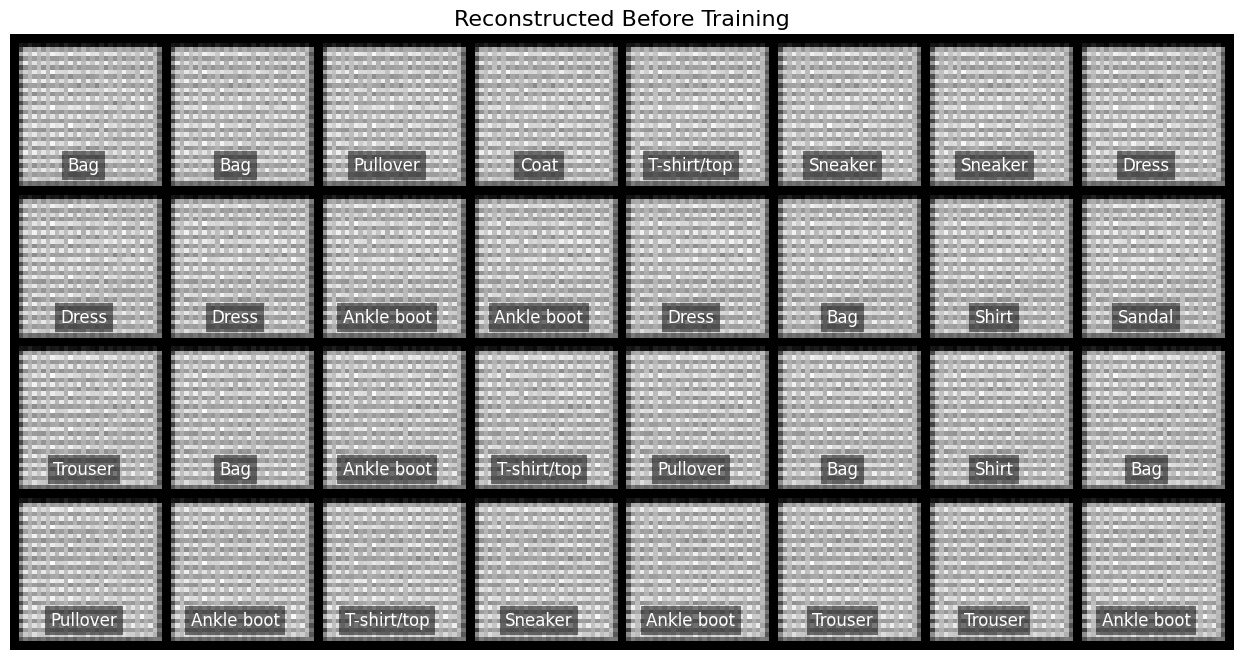

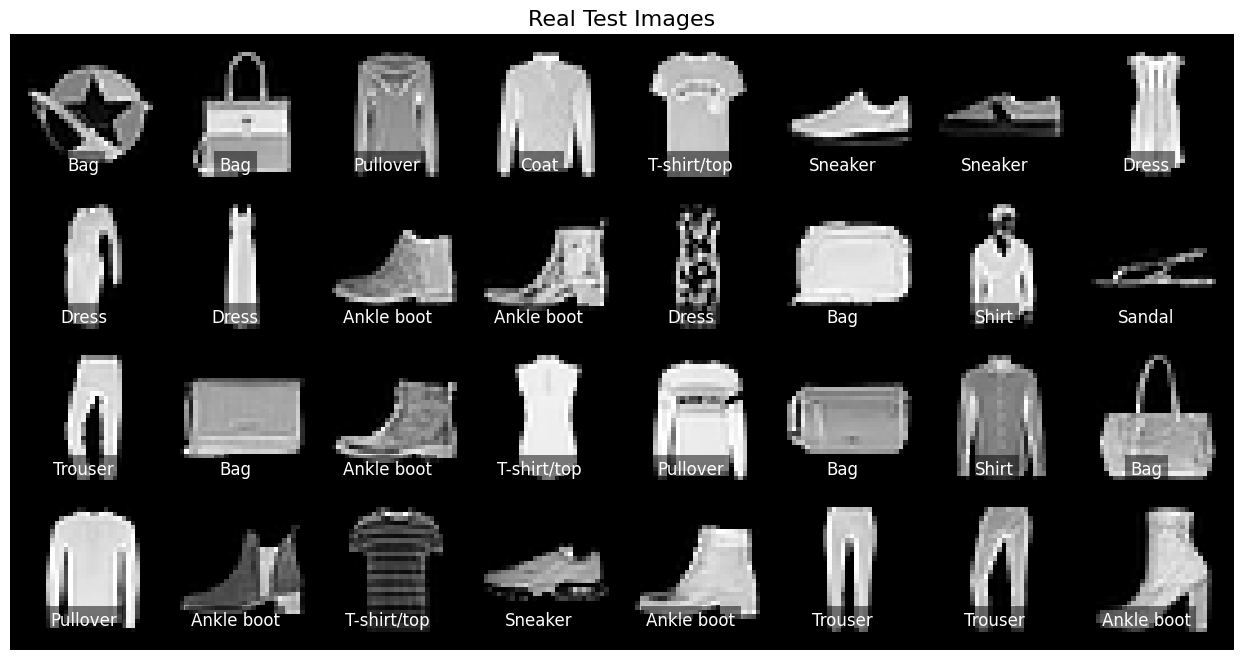

Epoch: 1/4


100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


Epoch 1 | Train Loss: 0.0204 | Val Loss: 0.0093
Epoch: 2/4


100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


Epoch 2 | Train Loss: 0.0076 | Val Loss: 0.0066
Epoch: 3/4


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch 3 | Train Loss: 0.0060 | Val Loss: 0.0056
Epoch: 4/4


100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


Epoch 4 | Train Loss: 0.0052 | Val Loss: 0.0049


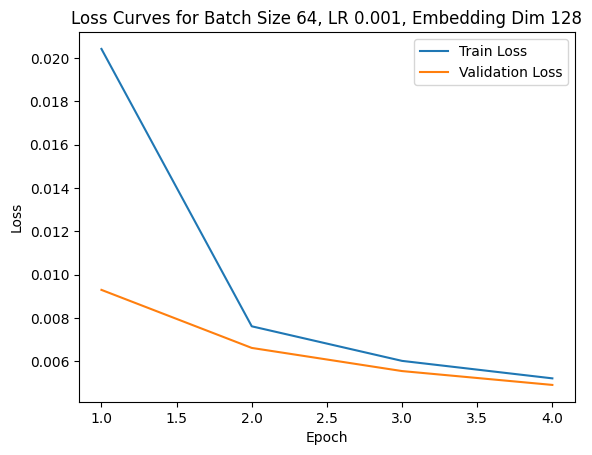

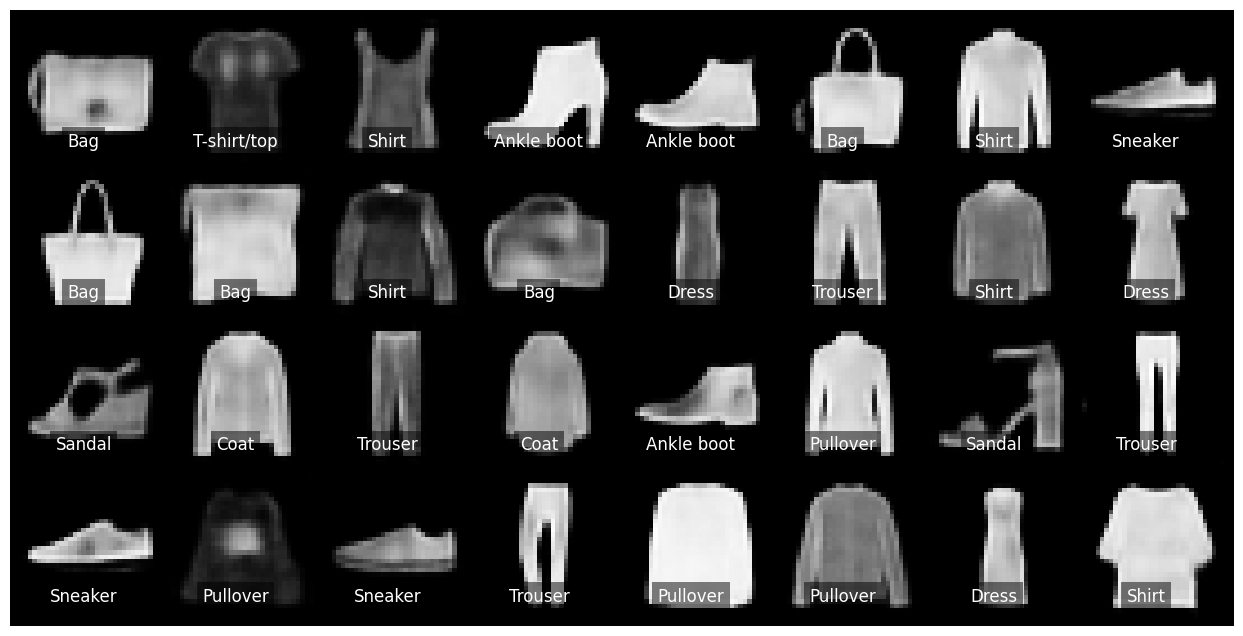

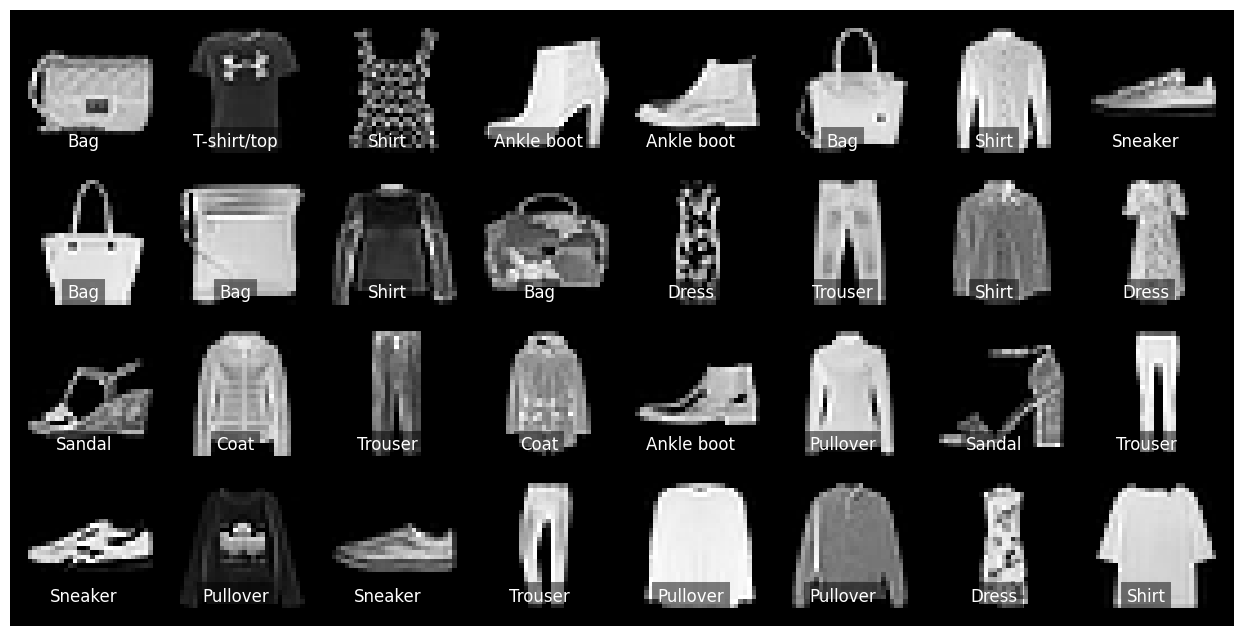

Testing combination: {'batch_size': 128, 'lr': 0.0001, 'embedding_dim': 64}
Epoch: 1/4


100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


Epoch 1 | Train Loss: 0.0661 | Val Loss: 0.0257
Epoch: 2/4


100%|██████████| 79/79 [00:06<00:00, 12.04it/s]


Epoch 2 | Train Loss: 0.0206 | Val Loss: 0.0178
Epoch: 3/4


100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


Epoch 3 | Train Loss: 0.0157 | Val Loss: 0.0140
Epoch: 4/4


100%|██████████| 79/79 [00:06<00:00, 13.16it/s]


Epoch 4 | Train Loss: 0.0130 | Val Loss: 0.0122


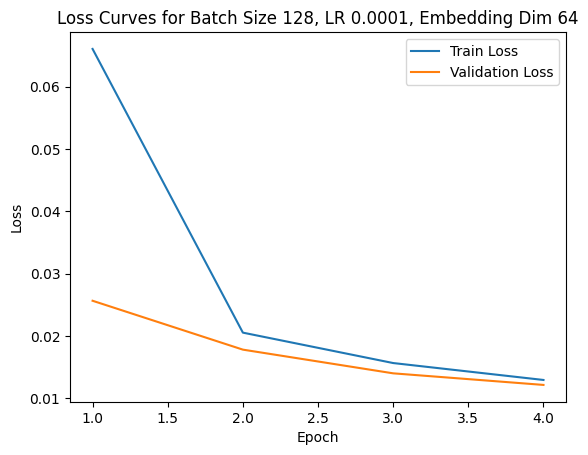

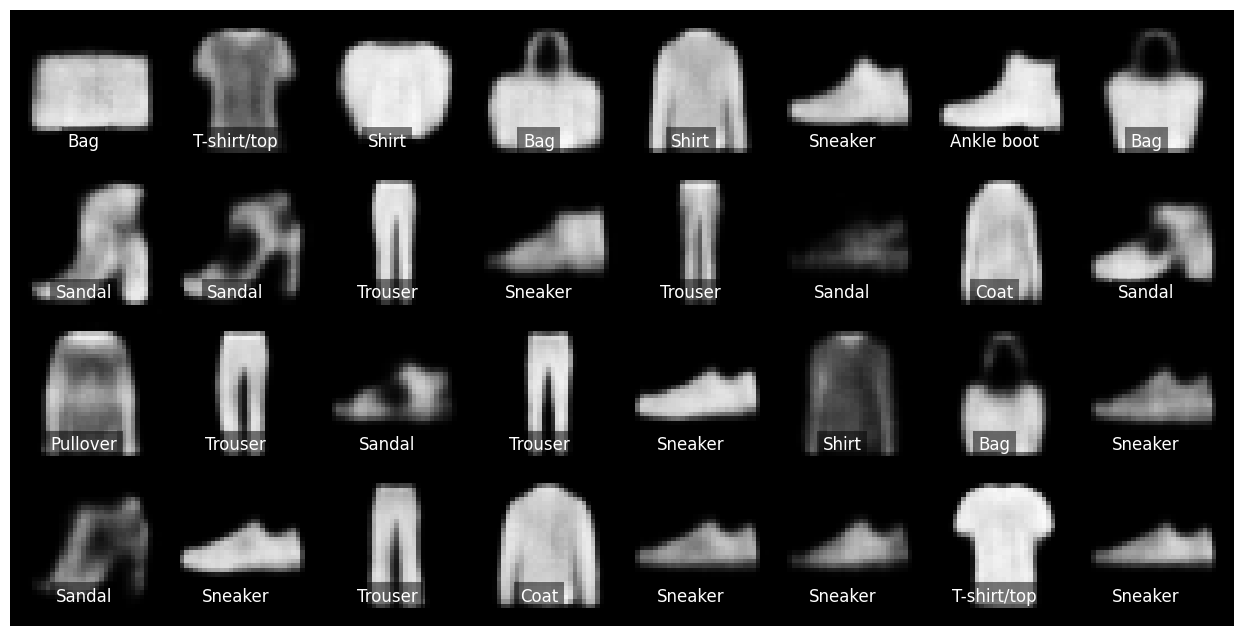

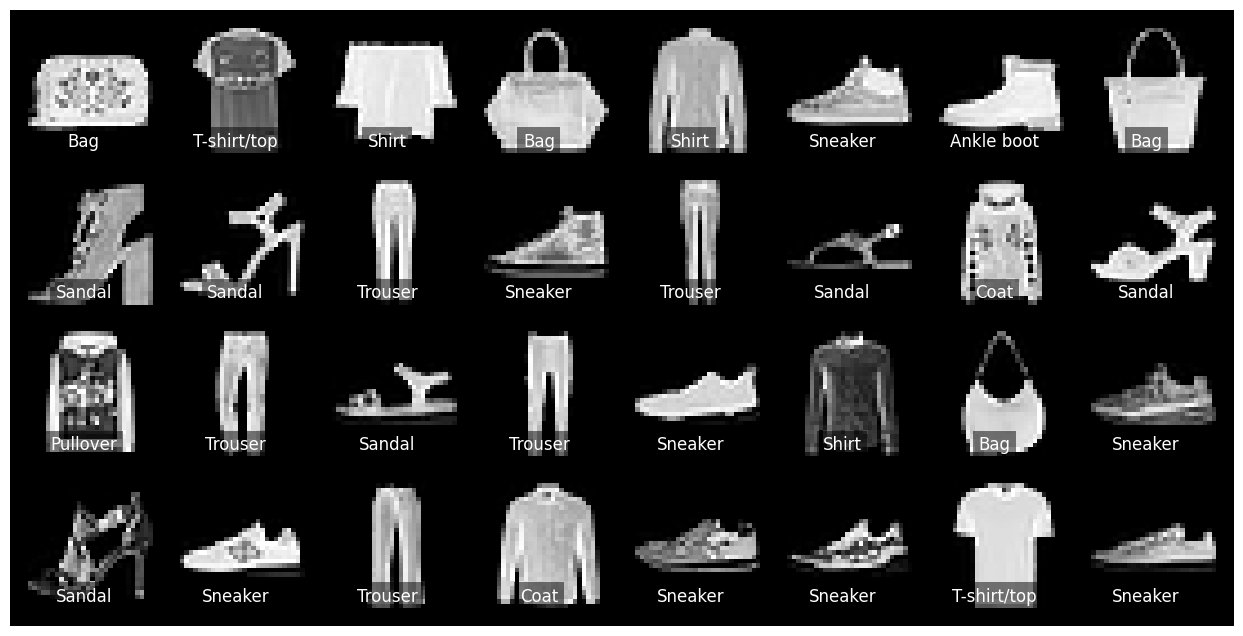

Testing combination: {'batch_size': 32, 'lr': 0.0005, 'embedding_dim': 256}
Epoch: 1/4


100%|██████████| 313/313 [00:07<00:00, 40.63it/s]


Epoch 1 | Train Loss: 0.0181 | Val Loss: 0.0085
Epoch: 2/4


100%|██████████| 313/313 [00:06<00:00, 45.79it/s]


Epoch 2 | Train Loss: 0.0072 | Val Loss: 0.0062
Epoch: 3/4


100%|██████████| 313/313 [00:06<00:00, 45.39it/s]


Epoch 3 | Train Loss: 0.0057 | Val Loss: 0.0052
Epoch: 4/4


100%|██████████| 313/313 [00:07<00:00, 44.70it/s]


Epoch 4 | Train Loss: 0.0049 | Val Loss: 0.0045


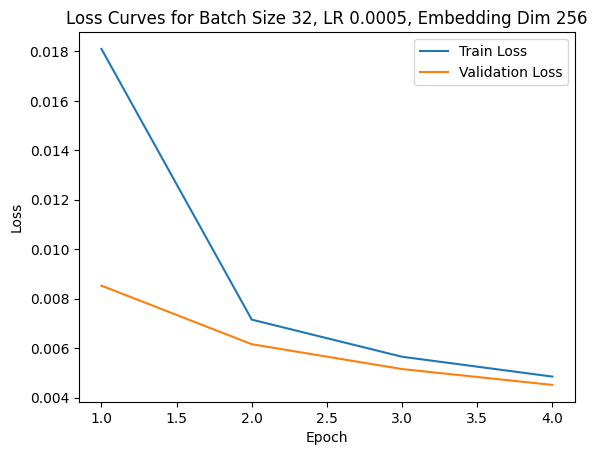

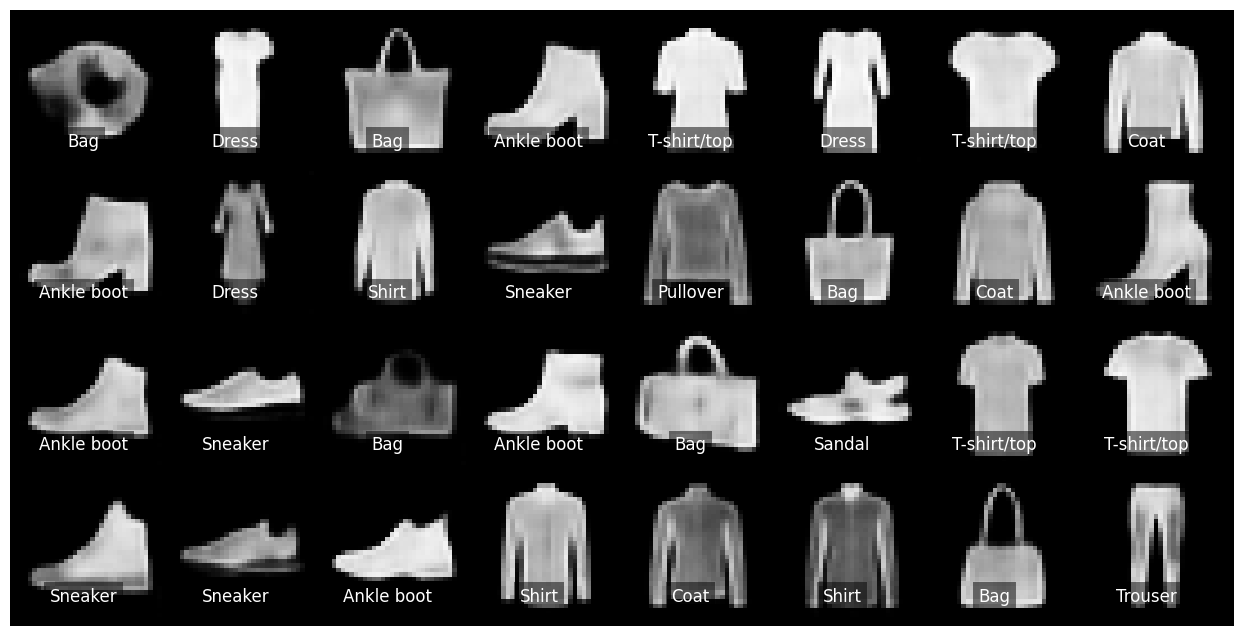

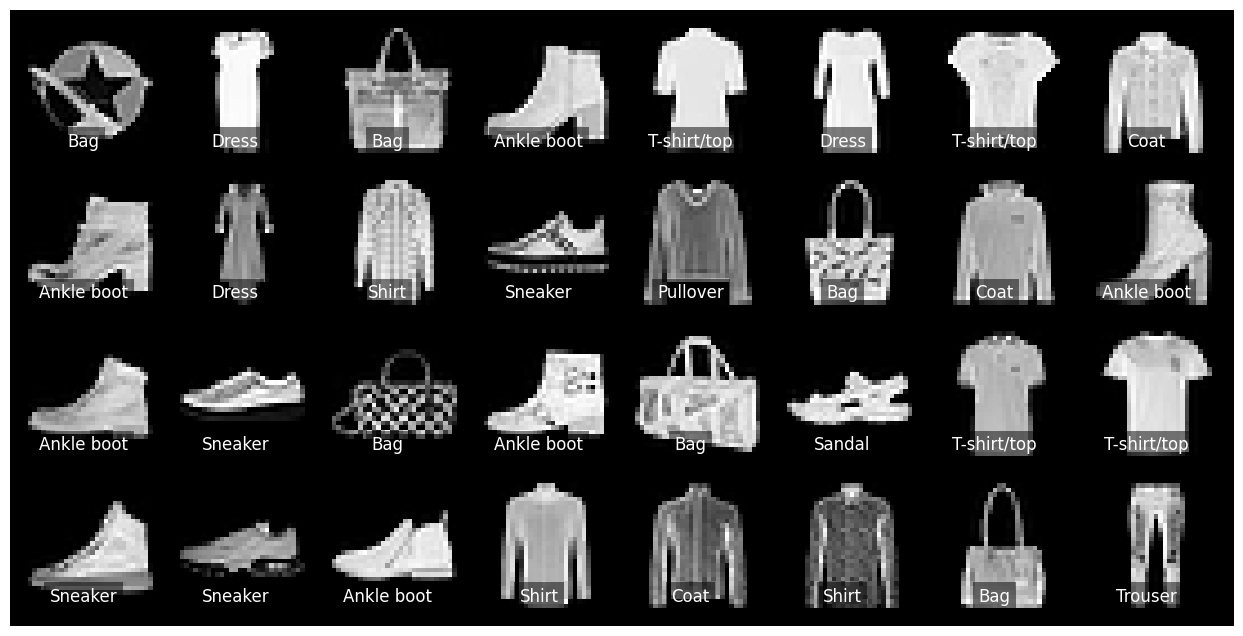

Training finished!


In [9]:
class Encoder(nn.Module):
    def __init__(self, image_size, channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.shape_before_flattening = None
        flattened_size = (image_size // 8) * (image_size // 8) * 128
        self.fc = nn.Linear(flattened_size, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        self.shape_before_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        self.reshape_dim = shape_before_flattening
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), *self.reshape_dim)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.conv1(x))
        return x






train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

train_labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)
test_labels = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
    features = F.pad(features, pad=(2, 2, 2, 2))
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)

train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)




# Hyperparameter combinations to test
hyperparameter_combinations = [
    {"batch_size": 64, "lr": 1e-3, "embedding_dim": 128},
    {"batch_size": 128, "lr": 1e-4, "embedding_dim": 64},
    {"batch_size": 32, "lr": 5e-4, "embedding_dim": 256},
]

# Loop through each hyperparameter combination
best_val_loss = float("inf")
best_model = None


# Define this to specify which combination to visualize before training
display_initial_reconstruction = {"batch_size": 64, "lr": 1e-3, "embedding_dim": 128}


for params in hyperparameter_combinations:
    print(f"Testing combination: {params}")
    BATCH_SIZE = params["batch_size"]
    LR = params["lr"]
    EMBEDDING_DIM = params["embedding_dim"]
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

    dummy_input = torch.randn(1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    encoder = Encoder(channels=CHANNELS, image_size=IMAGE_SIZE, embedding_dim=EMBEDDING_DIM).to(DEVICE)
    enc_out = encoder(dummy_input.to(DEVICE))

    shape_before_flattening = encoder.shape_before_flattening
    decoder = Decoder(EMBEDDING_DIM, shape_before_flattening, CHANNELS).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=PATIENCE)

        # Display random images before training for the specified combination
    if params == display_initial_reconstruction:
        display_random_images(
            test_loader, encoder, decoder, 
            title_recon="Reconstructed Before Training", 
            title_real="Real Test Images", 
            file_recon=FILE_RECON_BEFORE_TRAINING, 
            file_real=FILE_REAL_BEFORE_TRAINING
        )
    

    
    best_val_loss = float("inf")
        # Store losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        print(f"Epoch: {epoch + 1}/{EPOCHS}")
        encoder.train()
        decoder.train()
        running_loss = 0.0
        for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(DEVICE)
            optimizer.zero_grad()
            encoded = encoder(data)
            decoded = decoder(encoded)
            loss = criterion(decoded, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)


        val_loss = validate(encoder, decoder, test_loader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = {"encoder": encoder.state_dict(), "decoder": decoder.state_dict(), "params": params}
        
            
        scheduler.step(val_loss)
   
   


       # Plot the training and validation losses
    plt.figure()
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curves for Batch Size {BATCH_SIZE}, LR {LR}, Embedding Dim {EMBEDDING_DIM}")
    plt.legend()
    plt.show()




    display_random_images(data_loader=test_loader, encoder=encoder, decoder=decoder, file_recon=os.path.join(training_progress_dir, f"epoch{epoch + 1}_test_recon.png"), display_real=True)





torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict()}, MODEL_WEIGHTS_PATH)
print("Training finished!")




In [ ]:
# class Encoder(nn.Module):
#     def __init__(self, image_size, channels, embedding_dim):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
#         self.shape_before_flattening = None
#         flattened_size = (image_size // 8) * (image_size // 8) * 128
#         self.fc = nn.Linear(flattened_size, embedding_dim)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         self.shape_before_flattening = x.shape[1:]
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, embedding_dim, shape_before_flattening, channels):
#         super(Decoder, self).__init__()
#         self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
#         self.reshape_dim = shape_before_flattening
#         self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)

#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(x.size(0), *self.reshape_dim)
#         x = F.relu(self.deconv1(x))
#         x = F.relu(self.deconv2(x))
#         x = F.relu(self.deconv3(x))
#         x = torch.sigmoid(self.conv1(x))
#         return x





# train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
# test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

# train_labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)
# test_labels = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

# def preprocess_features(data):
#     features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
#     features = F.pad(features, pad=(2, 2, 2, 2))
#     return features

# train_features = preprocess_features(train_data)
# test_features = preprocess_features(test_data)

# train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
# test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)




# # Hyperparameter combinations to test
# hyperparameter_combinations = [
#     {"batch_size": 64, "lr": 1e-3, "embedding_dim": 128},
#     {"batch_size": 128, "lr": 1e-4, "embedding_dim": 64},
#     {"batch_size": 32, "lr": 5e-4, "embedding_dim": 256},
# ]

# # Loop through each hyperparameter combination
# best_val_loss = float("inf")
# best_model = None


# # Define this to specify which combination to visualize before training
# display_initial_reconstruction = {"batch_size": 64, "lr": 1e-3, "embedding_dim": 128}


# for params in hyperparameter_combinations:
#     print(f"Testing combination: {params}")
#     BATCH_SIZE = params["batch_size"]
#     LR = params["lr"]
#     EMBEDDING_DIM = params["embedding_dim"]
    
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

#     dummy_input = torch.randn(1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
#     encoder = Encoder(channels=CHANNELS, image_size=IMAGE_SIZE, embedding_dim=EMBEDDING_DIM).to(DEVICE)
#     enc_out = encoder(dummy_input.to(DEVICE))

#     shape_before_flattening = encoder.shape_before_flattening
#     decoder = Decoder(EMBEDDING_DIM, shape_before_flattening, CHANNELS).to(DEVICE)

#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=PATIENCE)

#         # Display random images before training for the specified combination
#     if params == display_initial_reconstruction:
#         display_random_images(
#             test_loader, encoder, decoder, 
#             title_recon="Reconstructed Before Training", 
#             title_real="Real Test Images", 
#             file_recon=FILE_RECON_BEFORE_TRAINING, 
#             file_real=FILE_REAL_BEFORE_TRAINING
#         )
    

    
#     best_val_loss = float("inf")
#         # Store losses for plotting
#     train_losses = []
#     val_losses = []

#     for epoch in range(EPOCHS):
#         print(f"Epoch: {epoch + 1}/{EPOCHS}")
#         encoder.train()
#         decoder.train()
#         running_loss = 0.0
#         for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             data = data.to(DEVICE)
#             optimizer.zero_grad()
#             encoded = encoder(data)
#             decoded = decoder(encoded)
#             loss = criterion(decoded, data)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
            
#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)


#         val_loss = validate(encoder, decoder, test_loader, criterion)
#         val_losses.append(val_loss)

#         print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = {"encoder": encoder.state_dict(), "decoder": decoder.state_dict(), "params": params}
        
            
#         scheduler.step(val_loss)
   
   


#        # Plot the training and validation losses
#     plt.figure()
#     plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
#     plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title(f"Loss Curves for Batch Size {BATCH_SIZE}, LR {LR}, Embedding Dim {EMBEDDING_DIM}")
#     plt.legend()
#     plt.show()




#     display_random_images(data_loader=test_loader, encoder=encoder, decoder=decoder, file_recon=os.path.join(training_progress_dir, f"epoch{epoch + 1}_test_recon.png"), display_real=True)





# torch.save({"encoder": encoder.state_dict(), "decoder": decoder.state_dict()}, MODEL_WEIGHTS_PATH)





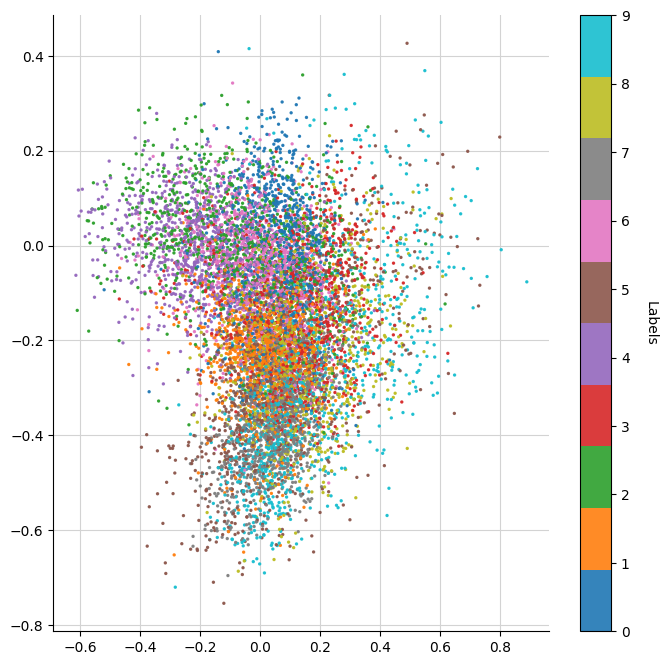

In [22]:



logging.info("Creating and Saving the Latent Space Plot of Trained Autoencoder")
plot_latent_space(test_loader, encoder, show=True)


In [25]:






import numpy as np

class AutoEncoder:
    def __init__(self, input_dim, hidden_layers, latent_dim, activation='relu', 
                 learning_rate=0.01, epochs=1000, batch_size=50, optimizer='sgd'):
        # Model parameters
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation_type = activation
        self.optimizer = optimizer

        # Encoder and Decoder architecture
        self.encoder_layers = [input_dim] + hidden_layers + [latent_dim]
        self.decoder_layers = [latent_dim] + hidden_layers[::-1] + [input_dim]

        # Initialize encoder weights and biases
        self.encoder_weights = [
            np.random.randn(self.encoder_layers[i], self.encoder_layers[i + 1]) * 0.01
            for i in range(len(self.encoder_layers) - 1)
        ]
        self.encoder_biases = [np.zeros((1, self.encoder_layers[i + 1])) for i in range(len(self.encoder_layers) - 1)]

        # Initialize decoder weights and biases
        self.decoder_weights = [
            np.random.randn(self.decoder_layers[i], self.decoder_layers[i + 1]) * 0.01
            for i in range(len(self.decoder_layers) - 1)
        ]
        self.decoder_biases = [np.zeros((1, self.decoder_layers[i + 1])) for i in range(len(self.decoder_layers) - 1)]

        # Set activation functions
        self.activation = self._get_activation_function(activation)
        self.activation_derivative = self._get_activation_derivative(activation)

    def _get_activation_function(self, activation):
        """Returns the appropriate activation function."""
        if activation == 'relu':
            return self.relu
        elif activation == 'sigmoid':
            return self.sigmoid
        elif activation == 'tanh':
            return self.tanh
        return self.linear  # Default to linear activation

    def _get_activation_derivative(self, activation):
        """Returns the appropriate activation derivative."""
        if activation == 'relu':
            return self.relu_derivative
        elif activation == 'sigmoid':
            return self.sigmoid_derivative
        elif activation == 'tanh':
            return self.tanh_derivative
        return self.linear_derivative

    def forward(self, X):
        """Forward pass through encoder and decoder."""
        self.encoder_activations = [X]
        self.decoder_activations = []

        # Encoder forward pass
        for i in range(len(self.encoder_weights)):
            z = np.dot(self.encoder_activations[-1], self.encoder_weights[i]) + self.encoder_biases[i]
            a = self.activation(z)
            self.encoder_activations.append(a)

        # Decoder forward pass
        for i in range(len(self.decoder_weights)):
            z = np.dot(self.decoder_activations[i - 1] if i > 0 else self.encoder_activations[-1], 
                       self.decoder_weights[i]) + self.decoder_biases[i]
            a = z if i == len(self.decoder_weights) - 1 else self.activation(z)
            self.decoder_activations.append(a)

        return self.decoder_activations[-1]

    def backward(self, X, y):
        """Backward pass to compute gradients."""
        gradients_encoder_weights = [np.zeros_like(w) for w in self.encoder_weights]
        gradients_encoder_biases = [np.zeros_like(b) for b in self.encoder_biases]
        gradients_decoder_weights = [np.zeros_like(w) for w in self.decoder_weights]
        gradients_decoder_biases = [np.zeros_like(b) for b in self.decoder_biases]

        # Compute error at output layer
        error = self.decoder_activations[-1] - y

        # Backpropagate through decoder
        for i in reversed(range(len(self.decoder_weights))):
            delta = error if i == len(self.decoder_weights) - 1 else delta.dot(self.decoder_weights[i + 1].T) * self.activation_derivative(self.decoder_activations[i])
            input_to_decoder = self.decoder_activations[i - 1] if i > 0 else self.encoder_activations[-1]
            gradients_decoder_weights[i] = np.dot(input_to_decoder.T, delta) / X.shape[0]
            gradients_decoder_biases[i] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]

        # Backpropagate through encoder
        delta = delta.dot(self.decoder_weights[0].T) * self.activation_derivative(self.encoder_activations[-1])
        for i in reversed(range(len(self.encoder_weights))):
            gradients_encoder_weights[i] = np.dot(self.encoder_activations[i].T, delta) / X.shape[0]
            gradients_encoder_biases[i] = np.sum(delta, axis=0, keepdims=True) / X.shape[0]
            if i != 0:
                delta = delta.dot(self.encoder_weights[i].T) * self.activation_derivative(self.encoder_activations[i])

        return gradients_encoder_weights, gradients_encoder_biases, gradients_decoder_weights, gradients_decoder_biases

    def update_parameters(self, gradients_encoder_weights, gradients_encoder_biases, 
                          gradients_decoder_weights, gradients_decoder_biases):
        """Update weights and biases using gradient descent."""
        clip_value = 5.
        for i in range(len(self.encoder_weights)):
            np.clip(gradients_encoder_weights[i], -clip_value, clip_value, out=gradients_encoder_weights[i])          
            self.encoder_weights[i] -= self.learning_rate * gradients_encoder_weights[i]
            np.clip(gradients_encoder_biases[i], -clip_value, clip_value, out=gradients_encoder_biases[i])
            self.encoder_biases[i] -= self.learning_rate * gradients_encoder_biases[i]

        for i in range(len(self.decoder_weights)):
            np.clip(gradients_decoder_weights[i], -clip_value, clip_value, out=gradients_decoder_weights[i])    
            self.decoder_weights[i] -= self.learning_rate * gradients_decoder_weights[i]
            np.clip(gradients_decoder_biases[i], -clip_value, clip_value, out=gradients_decoder_biases[i])
            self.decoder_biases[i] -= self.learning_rate * gradients_decoder_biases[i]

    def train(self, X):
        """Train the autoencoder."""
        for epoch in range(1, self.epochs + 1):
            y_pred = self.forward(X)  # Forward pass
            gradients = self.backward(X, X)  # Backward pass (target is input itself)
            self.update_parameters(*gradients)  # Update weights and biases

            # Compute loss and print every 100 epochs
            loss = self.compute_loss(X, y_pred)
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch}/{self.epochs} - Loss: {loss:.6f}")

    def compute_loss(self, X, y_pred):
        """Compute MSE loss."""
        return np.mean(np.square(X - y_pred))

    def encode(self, X):
        """Encode input data into the latent space."""
        activations = X
        for i in range(len(self.encoder_weights)):
            z = np.dot(activations, self.encoder_weights[i]) + self.encoder_biases[i]
            activations = self.activation(z)
        return activations

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, activated_x):
        return activated_x * (1 - activated_x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, activated_x):
        return np.where(activated_x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, activated_x):
        return 1 - np.power(activated_x, 2)

    def linear(self, x):
        return x

    def linear_derivative(self, activated_x):
        return np.ones_like(activated_x)







Epoch 1/4 - Loss: 0.211209
Epoch 1/4 - Loss: 0.193899
Epoch 1/4 - Loss: 0.191018
Epoch 1/4 - Loss: 0.172851
Epoch 1/4 - Loss: 0.176916
Epoch 1/4 - Loss: 0.161624
Epoch 1/4 - Loss: 0.162485
Epoch 1/4 - Loss: 0.180566
Epoch 1/4 - Loss: 0.147893
Epoch 1/4 - Loss: 0.142713
Epoch 1/4 - Loss: 0.131986
Epoch 1/4 - Loss: 0.102145
Epoch 1/4 - Loss: 0.106650
Epoch 1/4 - Loss: 0.117145
Epoch 1/4 - Loss: 0.092269
Epoch 1/4 - Loss: 0.096288
Epoch 1/4 - Loss: 0.086943
Epoch 1/4 - Loss: 0.090578
Epoch 1/4 - Loss: 0.084274
Epoch 1/4 - Loss: 0.084375
Epoch 1/4 - Loss: 0.098514
Epoch 1/4 - Loss: 0.085219
Epoch 1/4 - Loss: 0.084605
Epoch 1/4 - Loss: 0.088890
Epoch 1/4 - Loss: 0.090302
Epoch 1/4 - Loss: 0.086947
Epoch 1/4 - Loss: 0.081024
Epoch 1/4 - Loss: 0.080076
Epoch 1/4 - Loss: 0.092442
Epoch 1/4 - Loss: 0.088316
Epoch 1/4 - Loss: 0.092636
Epoch 1/4 - Loss: 0.094329
Epoch 1/4 - Loss: 0.090798
Epoch 1/4 - Loss: 0.083385
Epoch 1/4 - Loss: 0.086197
Epoch 1/4 - Loss: 0.089505
Epoch 1/4 - Loss: 0.090585
E

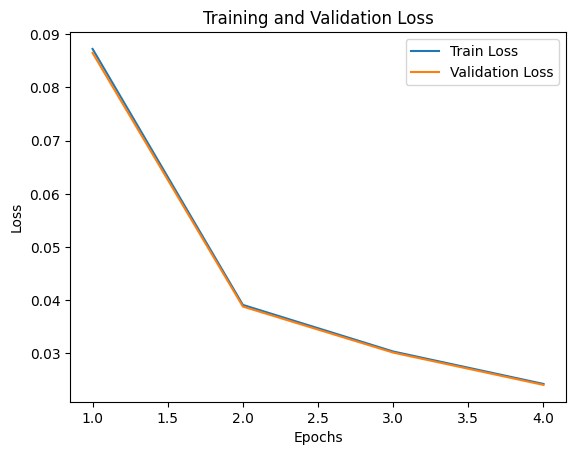

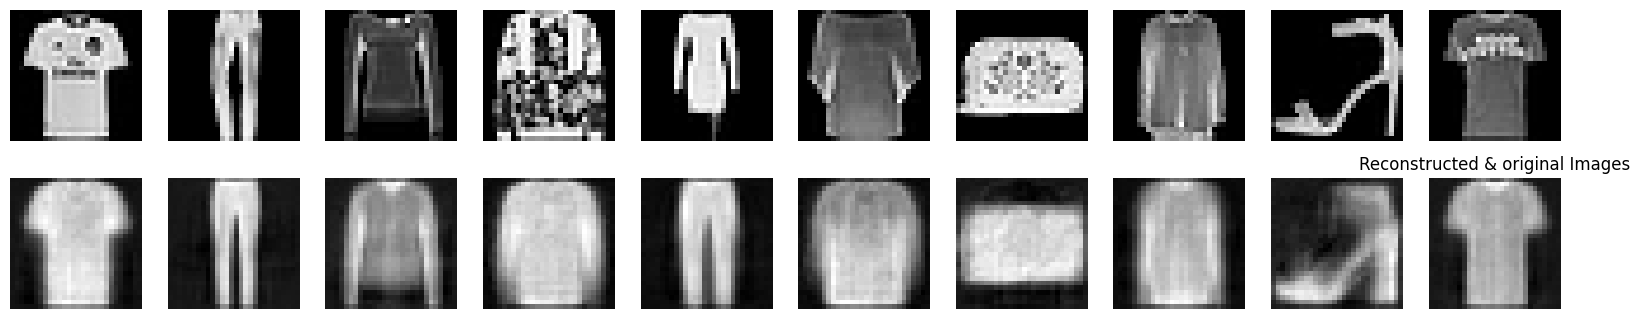

In [26]:
from sklearn.model_selection import train_test_split



train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')


# Extract features and labels
label = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)  # Extract the label column


# Extract features and normalize
def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)

# Split train_features into training and validation sets
train_features, val_features, train_label, val_label = train_test_split(train_features, label, test_size=0.2, random_state=42)

# Convert data to NumPy arrays for compatibility with the custom AutoEncoder class
train_features_np = train_features.numpy()
val_features_np = val_features.numpy()
train_label_np = train_label.numpy()
val_label_np = val_label.numpy()
# Set up the autoencoder
input_dim = 784
hidden_layers = [128, 64]  # Example hidden layer sizes
latent_dim = 32
epochs = 4
batch_size = 64

autoencoder = AutoEncoder(input_dim, hidden_layers, latent_dim, epochs=epochs, batch_size=batch_size)

# Training loop
train_losses, val_losses = [], []
for epoch in range(1, epochs + 1):
    # Shuffle training data in batches
    np.random.shuffle(train_features_np)
    for i in range(0, train_features_np.shape[0], batch_size):
        batch_X = train_features_np[i:i + batch_size]
        autoencoder.train(batch_X)

    # Compute losses
    train_loss = autoencoder.compute_loss(train_features_np, autoencoder.forward(train_features_np))
    val_loss = autoencoder.compute_loss(val_features_np, autoencoder.forward(val_features_np))
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# Select a few test samples to reconstruct
n_samples = 10
test_samples = test_features[:n_samples].numpy()

# Get the reconstructed outputs
reconstructed_samples = autoencoder.forward(test_samples)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
for i in range(n_samples):
    # Original images
    axes[0, i].imshow(test_samples[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructed_samples[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original')
axes[1, 0].set_ylabel('Reconstructed')
plt.title('Reconstructed & original Images')
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.all_eigenvalues_ = None

    def fit(self, X):
        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Compute covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Sort eigenvalues and eigenvectors
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        # Store all eigenvalues for scree plot
        self.all_eigenvalues_ = eigenvalues
        # Select the top n_components
        self.components_ = eigenvectors[:, :self.n_components]
        self.explained_variance_ = eigenvalues[:self.n_components]

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components_.T) + self.mean_

    def checkPCA(self, X, tolerance=62):
        X_transformed = self.transform(X)
        X_reconstructed = self.inverse_transform(X_transformed)
        
        # Calculate reconstruction error
        error = np.linalg.norm(X - X_reconstructed)
        
        # Return True if the reconstruction error is within the tolerance
        return error < tolerance
    
    def plot_scree_plot(self, eigenvalues):
    # Number of principal components
        n_components = len(eigenvalues)
        
        # Plot the scree plot
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, n_components + 1), eigenvalues, 'o-', linewidth=2, color='blue')
        plt.title('Scree Plot')
        plt.xlabel('Principal Components')
        plt.ylabel('Eigenvalue')
        plt.grid(True)
        plt.show()


from sklearn.model_selection import train_test_split


train_actual = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_actual = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
# Extract features and labels
train_actual = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)  # Extract the label column
test_actual = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)    # Similarly for test data

# Extract features and normalize
def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)

# Split train_features into training and validation sets
train_features, val_features = train_test_split(train_features, test_size=0.2, random_state=42)

# Convert data to NumPy arrays for compatibility with the custom AutoEncoder class
train_features_np = train_features.numpy()
val_features_np = val_features.numpy()

print(train_actual)



tensor([2, 9, 6,  ..., 8, 8, 7])


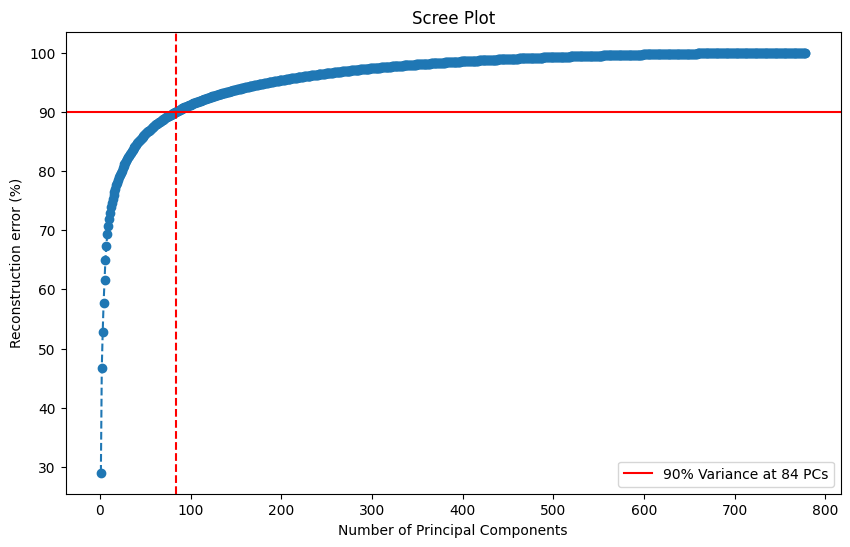

In [50]:
from sklearn.model_selection import train_test_split



train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')


# Extract features and labels
train_label = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)  # Extract the label column
val_label = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)    # Similarly for test data

train_label = train_label.numpy()
val_label = val_label.numpy()
# Extract features and normalize
def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
    return features

train_features = preprocess_features(train_data)
val_features = preprocess_features(test_data)

# Convert data to NumPy arrays for compatibility with the custom AutoEncoder class
train_features_np = train_features.numpy()
val_features_np = val_features.numpy()





import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA with the desired number of components
pca = PCA(n_components=778)
pca.fit(train_features_np)

# Calculate explained variance ratio (percentage) and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the number of components that explain at least 90% variance
threshold = 90
components_90_pct = np.argmax(cumulative_explained_variance_ratio >= threshold) + 1  # +1 for indexing

# Plot the cumulative explained variance using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'90% Variance at {components_90_pct} PCs')
plt.axvline(x=components_90_pct, color='r', linestyle='--')

# Add labels and title
plt.title("Scree Plot")
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction error (%)")
plt.legend(loc='best')

# Show the plot
plt.show()






In [48]:
optimal_dims = 84 # Number of dimensions chosen from the scree plot
pca_optimal = PCA(n_components=optimal_dims)
reduced_data = pca_optimal.fit_transform(train_features_np)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import torch



# Initialize KNN model with k=3 (you can adjust k as needed)
knn = KNeighborsClassifier(n_neighbors=10)

# Train the model on the training data
knn.fit(train_features_np, train_label)

# Evaluate the model on the validation data
val_predictions = knn.predict(val_features)
val_accuracy = accuracy_score(val_label, val_predictions)
print(f"KNN Accuracy on PCA encoder : {val_accuracy*100:.4f}%")




train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

train_labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)
test_labels = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0
    features = F.pad(features, pad=(2, 2, 2, 2))
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)


# Step 1: Extract Bottleneck Features from Encoder for Train and Test Data
def extract_features(encoder, data_loader):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(DEVICE)
            encoded = encoder(data)
            features.append(encoded.cpu())
            labels.append(label)
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels

# Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 2: Get Bottleneck Features for Train and Test Sets
train_features, train_labels = extract_features(encoder, train_loader)
test_features, test_labels = extract_features(encoder, test_loader)

# Step 3: Train KNN on Bottleneck Features
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(train_features, train_labels)

# Step 4: Predict and Evaluate Accuracy
predictions = knn.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Accuracy on CNN encoder: {accuracy * 100:.2f}%")



train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')



# Remove padding and flatten the data
def preprocess_features(data):
    features = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 28 * 28) / 255.0
    return features

train_features = preprocess_features(train_data)
test_features = preprocess_features(test_data)

train_features_np = train_features.numpy()
val_features_np = test_features.numpy()

# Step 1: Encode the train and validation data using the bottleneck layer
train_encoded = autoencoder.encode(train_features_np)  # Pass train features through encoder
val_encoded = autoencoder.encode(val_features_np)      # Pass validation features through encoder

# Step 2: Train a KNN classifier on the bottleneck layer output (encoded features)
knn = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values for k
knn.fit(train_encoded, train_labels)  # No need to call .numpy() on train_labels

# Step 3: Predict and calculate accuracy
val_predictions = knn.predict(val_encoded)
accuracy = accuracy_score(test_labels, val_predictions)  # No need to call .numpy() on test_labels

print(f"KNN Accuracy on MLP encoder: {accuracy*100:.4f}%")




KNN Accuracy on PCA encoder : 85.7300%
KNN Accuracy on CNN encoder: 87.25%
KNN Accuracy on MLP encoder: 74.6300%
